In [20]:
%%time
# for development, changes in other modules have to be reloaded to reflect changes
%load_ext autoreload
%autoreload 1

import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn 
import os, sys
import SimpleITK as sitk

%aimport config 
sys.path.append(config.lib_dir)
%aimport utils
%aimport segment 
%aimport match 
%aimport register 
%aimport evaluate 
%aimport qc 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 667 µs


From readme...


manual QC can be performed by passing either a dictionary (in results.ipynb) or as a json file (restitch_cores.py --qc /path/to/file.json) of cores that should not be restiched. For an example of a properly formatted json file, see here.

```json
{
    "R0":[23,3,42,35,19,79,17,22],
    "R1":[15,12,60,54,48,38,70,62],
    "R2":[30,46,8,24,80,9,31,44,76]
}
```

In [21]:
res = pd.read_csv('/mnt/e/CycIF_analysis/registration_outputs/test_core_reg/aggregated_results.csv')

res = res.assign(round_num = [int(x[1:]) for x in res['round'].values])

# select only registered results -- keep R0 unregistered as this is the aligned reference 
reg_res = res[(res.status == 'registered') | (res['round'] == 'R0')]

reg_res.head()

,status,core,round,color_channel,path,img_name,protein,center_x,center_y,width,...,scene,note,jacaard_coef,dice_coef,volume_similarity,false_pos_err,false_neg_err,hausdorff_dist,registered_path,round_num
0,registered,0,R4,c1,registered_core=0_round=R4_color=c1.tif,R4_pATR.CCNB1.CD4.53BP1_D1_2020_10_07__9253_c1...,pATR.CCNB1.CD4.53BP1,4,335,79,...,None,ORG,0.317959,0.482502,0.491354,0.612659,0.360351,398.448246,/mnt/e/CycIF_analysis/registration_outputs/tes...,4
1,registered,0,R4,c2,registered_core=0_round=R4_color=c2.tif,NaN,NaN,4,335,79,...,None,ORG,0.317959,0.482502,0.491354,0.612659,0.360351,398.448246,/mnt/e/CycIF_analysis/registration_outputs/tes...,4
2,registered,0,R4,c3,registered_core=0_round=R4_color=c3.tif,NaN,NaN,4,335,79,...,None,ORG,0.317959,0.482502,0.491354,0.612659,0.360351,398.448246,/mnt/e/CycIF_analysis/registration_outputs/tes...,4
3,registered,0,R4,c4,registered_core=0_round=R4_color=c4.tif,NaN,NaN,4,335,79,...,None,ORG,0.317959,0.482502,0.491354,0.612659,0.360351,398.448246,/mnt/e/CycIF_analysis/registration_outputs/tes...,4
4,registered,0,R4,c5,registered_core=0_round=R4_color=c5.tif,NaN,NaN,4,335,79,...,None,ORG,0.317959,0.482502,0.491354,0.612659,0.360351,398.448246,/mnt/e/CycIF_analysis/registration_outputs/tes...,4


# Regress out Round effects 

<AxesSubplot:xlabel='round_num', ylabel='dice_coef'>

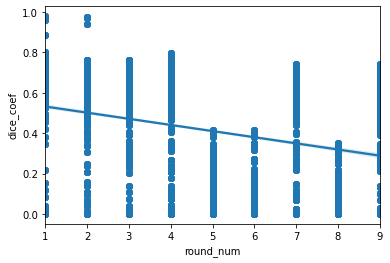

In [22]:
sbn.regplot(x='round_num', y='dice_coef', data=reg_res)

<AxesSubplot:xlabel='core', ylabel='dice_coef'>

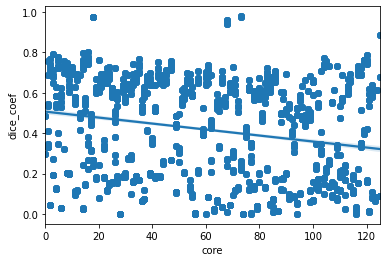

In [23]:
sbn.regplot(x='core', y='dice_coef', data=reg_res)

In [9]:
reg_res.columns.tolist()

['status',
 'core',
 'round',
 'color_channel',
 'path',
 'img_name',
 'protein',
 'center_x',
 'center_y',
 'width',
 'height',
 'Volume (nm^3)',
 'Elongation',
 'Flatness',
 'Oriented Bounding Box Minimum Size(nm)',
 'Oriented Bounding Box Maximum Size(nm)',
 'Intensity Mean',
 'Intensity Standard Deviation',
 'Intensity Skewness',
 'component',
 'slide_name',
 'date',
 'scan_id',
 'scene',
 'note',
 'jacaard_coef',
 'dice_coef',
 'volume_similarity',
 'false_pos_err',
 'false_neg_err',
 'hausdorff_dist',
 'registered_path',
 'round_num']

<AxesSubplot:xlabel='Volume (nm^3)', ylabel='dice_coef'>

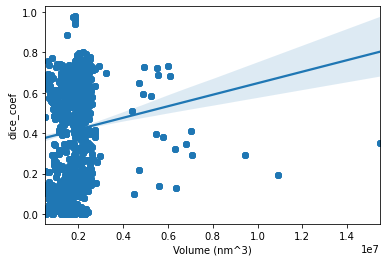

In [24]:
sbn.regplot(x='Volume (nm^3)', y='dice_coef', data=reg_res)

<AxesSubplot:xlabel='center_x', ylabel='dice_coef'>

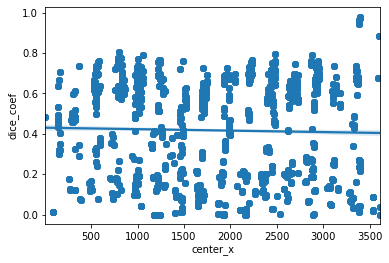

In [25]:
sbn.regplot(x='center_x', y='dice_coef', data=reg_res)

<AxesSubplot:xlabel='center_y', ylabel='dice_coef'>

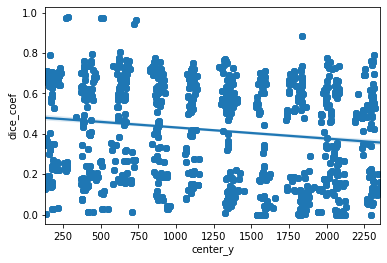

In [26]:
sbn.regplot(x='center_y', y='dice_coef', data=reg_res)

In [27]:
stats = reg_res.groupby('round')['dice_coef'].agg(['mean', 'std']).reset_index()
stats=stats.rename({'mean':'mean_dice', 'std':'std_dice'}, axis=1)
reg_res = reg_res.merge(stats, on ='round', how='left').assign(dice_zeroed=lambda x: x.dice_coef - x.mean_dice)

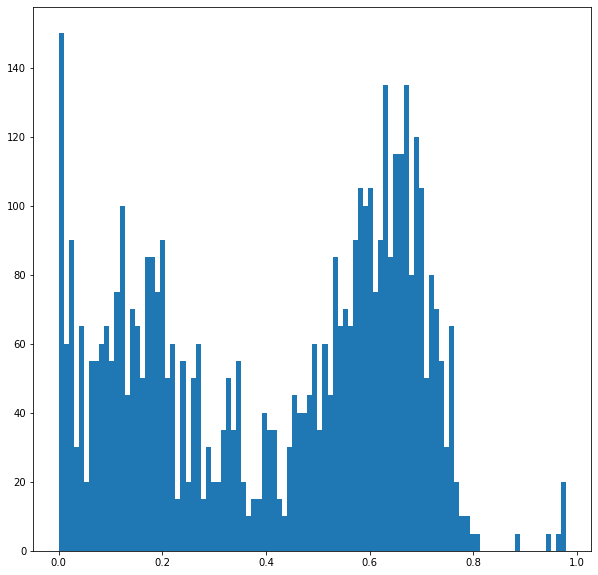

In [29]:
plt.figure(figsize=(10,10))
plt.hist(reg_res.dice_coef, bins=100)
plt.show()

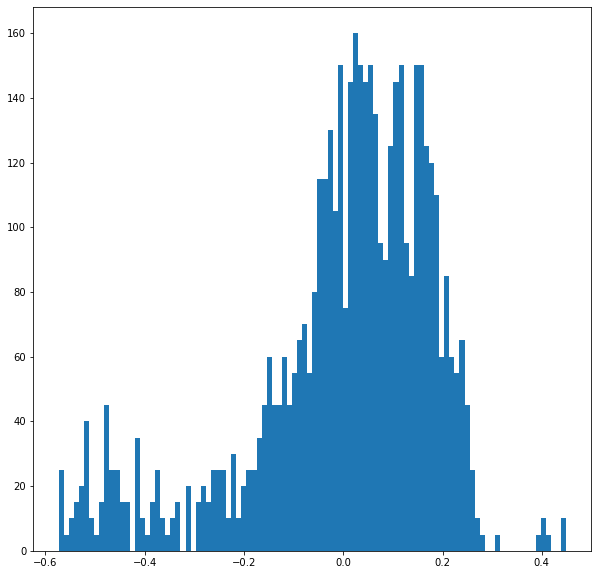

In [28]:
plt.figure(figsize=(10,10))
plt.hist(reg_res.dice_zeroed, bins=100)
plt.show()

<AxesSubplot:xlabel='core', ylabel='dice_zeroed'>

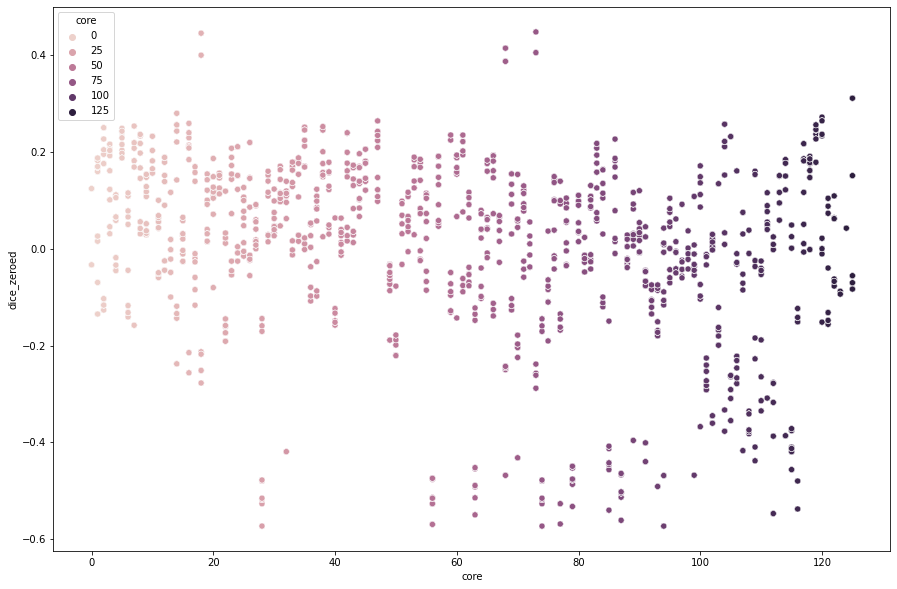

In [15]:
plt.figure(figsize=(15,10))
sbn.scatterplot(x='core', y='dice_zeroed', hue='core', data=reg_res)

<AxesSubplot:xlabel='core', ylabel='round_num'>

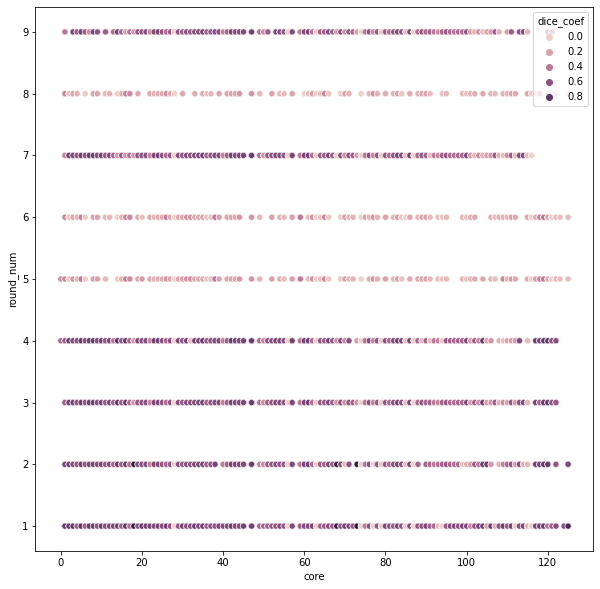

In [17]:
plt.figure(figsize=(10,10))
sbn.scatterplot(x='core', y='round_num', hue='dice_coef', data=reg_res)

# Let's look at registration improvement 
(core level) 

In [30]:
# select only registered results -- keep R0 unregistered as this is the aligned reference 
res.head()

,status,core,round,color_channel,path,img_name,protein,center_x,center_y,width,...,scene,note,jacaard_coef,dice_coef,volume_similarity,false_pos_err,false_neg_err,hausdorff_dist,registered_path,round_num
0,registered,0,R4,c1,registered_core=0_round=R4_color=c1.tif,R4_pATR.CCNB1.CD4.53BP1_D1_2020_10_07__9253_c1...,pATR.CCNB1.CD4.53BP1,4,335,79,...,None,ORG,0.317959,0.482502,0.491354,0.612659,0.360351,398.448246,/mnt/e/CycIF_analysis/registration_outputs/tes...,4
1,registered,0,R4,c2,registered_core=0_round=R4_color=c2.tif,NaN,NaN,4,335,79,...,None,ORG,0.317959,0.482502,0.491354,0.612659,0.360351,398.448246,/mnt/e/CycIF_analysis/registration_outputs/tes...,4
2,registered,0,R4,c3,registered_core=0_round=R4_color=c3.tif,NaN,NaN,4,335,79,...,None,ORG,0.317959,0.482502,0.491354,0.612659,0.360351,398.448246,/mnt/e/CycIF_analysis/registration_outputs/tes...,4
3,registered,0,R4,c4,registered_core=0_round=R4_color=c4.tif,NaN,NaN,4,335,79,...,None,ORG,0.317959,0.482502,0.491354,0.612659,0.360351,398.448246,/mnt/e/CycIF_analysis/registration_outputs/tes...,4
4,registered,0,R4,c5,registered_core=0_round=R4_color=c5.tif,NaN,NaN,4,335,79,...,None,ORG,0.317959,0.482502,0.491354,0.612659,0.360351,398.448246,/mnt/e/CycIF_analysis/registration_outputs/tes...,4


# after accounting for round effect... 

## Which cores have the worst average registration across all rounds? 

Let's rank

In [18]:
# without accounting for round
stats2 = reg_res.groupby('core')['dice_coef'].agg(['mean', 'std']).reset_index().rename({'mean':'mean_dice_per_core', 'std':"std_dice_per_core"}, axis=1)
stats2.sort_values('mean_dice_per_core')

,core,mean_dice_per_core,std_dice_per_core
71,74,0.000000,0.000000
28,28,0.000100,0.000147
54,56,0.002404,0.001726
84,87,0.013004,0.000516
113,116,0.018771,0.011518
...,...,...,...
21,21,0.651025,0.022519
51,53,0.655102,0.029442
7,7,0.661060,0.156161
45,45,0.677131,0.023602


In [19]:
stats2 = reg_res.groupby('core')['dice_zeroed'].agg(['mean', 'std']).reset_index().rename({'mean':'mean_dice_per_core', 'std':"std_dice_per_core"}, axis=1)
stats2.sort_values('mean_dice_per_core')

,core,mean_dice_per_core,std_dice_per_core
54,56,-0.512873,0.032816
84,87,-0.502273,0.032875
76,79,-0.479366,0.027819
82,85,-0.407882,0.114623
71,74,-0.396242,0.172390
...,...,...,...
38,38,0.169985,0.067430
46,47,0.183518,0.061251
10,10,0.188044,0.028030
5,5,0.221007,0.021895


In [ ]:
#reg_res2 = reg_res.merge(stats2, on='core', how='left').sort_values('mean_dice_per_core').reset_index(drop=True)
#reg_res.head(10)